#### Assignment 4 - 158.755 - S01 2021
##### James Bristow - 11189075
##### Martin Brenner - 20022611
***
<center><h1>Dolphin Photo-Identification</h1><h3>Identification of individual dolphins based on their dorsal fin</h3></center>

## Abstract
In this report, we document how we identify individual dolphins based on their dorsal fin.<br> 

For this task, a system was designed that can take a file or directory, showing dorsal fins, as an input and produce a prediction of which individual can be seen on the photo. For the fin detection process, a Darknet YOLOv4 network was trained on the public NDD20 dolphin fin dataset. In a second step, each fin is automatically cropped from the image and put through some pre-processing to enhance its features. For the identification of the individual dolphin, a Triplet Loss Neural Network was configured. The network was trained on a cleaned and labelled data set of individual dolphin fins provided by NIWA marine researchers. According to these marine scientists, it may be possible to identify individual dolphins using their fin pigmentation patterns.<br> UMAP is then used to visualise the network embeddings, and clusters of individuals are high-lighted using HDBSCAN.<br> A software solution combining all steps was produced using the Flask web server and Vue.js front-end, which enables the user to upload a batch of photos which are then put through the identification process. The final software solution allows users to visualise the neural network embeddings, identify clusters and outliers, sort images by the estimated class label (the individual dolphin), and import and export datasets in csv and json format.

## Introduction
The identification of individual dolphins is of relevance to researchers who want to distinguish and catalog them for study purposes. The task of matching individuals by visual comparison is time consuming, tedious, and prone to error. We propose a system that can aide in this identification process via a machine learning pipeline.

In this report, we first perform an exploratory data analysis of the NDD20 and pigmentation datasets. We consider individual images, and identify their most signficant features. We perform extensive pre-processing on these images, and note the limitations of the provided datasets. 

We've trained a YOLOv4 convolutional neural network on the NDD20 dataset using a Darknet architecture. Images were annotated using labelimg. Bounding box data has been stored in the YOLO-format. We next used OpenCV load the trained Darknet model, make predictions, and automatically crop the images.

The FaceNet implementation of triplet loss was subsequently used to train a neural network for individual dolphin recognition. This neural network was trained on a catalogue of pre-labelled dolphin images. FaceNet was used as the backbone network, which we connected with the Keras framework for use on our own project. 

Next, we deployed these algorithms on a web application via a Docker stack. We used a Flask webserver for the backend application logic, and a Vue.js frontend for the graphical user interface. Nginx was used as a proxy webserver to improve the theoretical scability of the application, by facilitating load-balancing and caching. Redis was used as a caching system, message broker, and a job queue. Celery workers were used to asynchronously perform the more computationally-expensive machine learning tasks without disrupting the performance of the application. 

The project's GitHub repository can be found here: https://github.com/JBris/dolphin_segmentation

In [1]:
# Imports 
import os
import random
import shutil
from glob import glob
from IPython.display import display, HTML, Image
import matplotlib.pyplot as plt
import pandas as pd
from pathlib import Path
import cv2

# Constants
SEED = 100
TEST_PROP =  0.15

In [2]:
IMAGES_DIR = '../images'
MODEL_DIR = '../models/darknet'
MODEL_DIR_TL = '../models/finnet'
data_dir = IMAGES_DIR + "/NDD20/"
file_dir = f"{data_dir}data/"
files = glob(f'{file_dir}*.jpg')

## 1. Exploratory Data Analysis
For the project two public datasets were used:
1) NDD20: https://arxiv.org/abs/2005.13359 for the detection<br>
2) NIWA marine researchers: Provided fin images for the identification process https://niwa.co.nz/news/know-your-dolphin-by-the-fin-says-niwa-scientist

The two datasets used came labelled and there was only a small conversion from the COCO to YOLO data format, required to use NDD20 with the YOLO network.<br>
The pigmentation dataset was provided with a folder structure with background cleaned images of fins in directories for each individual.<br>

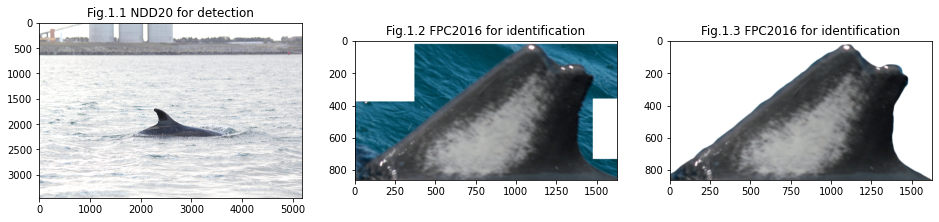

In [50]:
images_dir = IMAGES_DIR+'/final_pigmentation_catalogue_2016'
img_ndd20 = cv2.imread(data_dir+"/data/8.jpg")
img_fpc = cv2.imread(images_dir+"/0002/HG_100429_011_SD.png", cv2.IMREAD_UNCHANGED) 

plt.figure(figsize=(16,10))
plt.subplot(131)
plt.imshow(cv2.cvtColor(img_ndd20, cv2.COLOR_BGR2RGB)); plt.title("Fig.1.1 NDD20 for detection")
plt.subplot(132)
plt.imshow(cv2.cvtColor(img_fpc, cv2.COLOR_BGR2RGB)); plt.title("Fig.1.2 FPC2016 for identification")
plt.subplot(133)
plt.imshow(cv2.cvtColor(img_fpc, cv2.COLOR_BGRA2RGBA)); plt.title("Fig.1.3 FPC2016 for identification");

Fig.1.1 shows a sample of the images used for the fin detection. The bounding box coordinates for the fin(s) were included.<br>Fig.1.2 shows one of the images provided for identification. As the image was converted to three channels (RGB) it became apparent that some of the images still had the background pixels present which were just hidden behind an alpha transparency mask in the png file. This would cause issues as the network which will be trained for the identification only uses three channels of the image. Because of this a pre-processing step to remove the pixels is required. Fig.1.3. shows the image including the alpha channel.

In [11]:
len(files)

2201

The NDD20 dataset contains 2201 images - all jpg files.

Next, we will explore the pigmentation dataset.

In [24]:
pigmentation_dir = IMAGES_DIR + "/final_pigmentation_catalogue_2016/"
pigmentation_files = glob(f'{pigmentation_dir}/*/*.png')

In [38]:
pigmentation_files[0:5]
len(pigmentation_files)

3746

There are 3746 images within the pigmentation dataset.

In [28]:
pigmentation_classes = glob(f'{pigmentation_dir}/*')
len(pigmentation_classes)

186

There are different 186 dolphin pigmentation classes

In [51]:
df_rows = []

for pigmentation_class in pigmentation_classes:
    for image_file in glob(pigmentation_class + '/*.png'):
        df_row = {"identity": Path(pigmentation_class).name, "image": Path(image_file).name }
        df_rows.append(df_row)
        
pigmentation_df = pd.DataFrame(df_rows)

In [52]:
pigmentation_df.head(5)

,identity,image
0,0548,HG_110923_100_E2_N3.png
1,0548,HG_130711_093_E4_CL_N7.png
2,0548,HG_130720_0333_E1_CL_AII.png
3,0548,HG_130720_0334_E1_CL_AII.png
4,0548,HG_130720_0359_E1_CL_AII.png


We can see that the pigmentation dataset is composed of png files.

In [53]:
pigmentation_df.groupby('identity').size().reset_index(name='counts').sort_values('counts', ascending=False).head(5)

,identity,counts
60,0277,86
43,0187,75
152,0807,60
145,0769,59
119,0522,57


We can see above the top 5 classes.

In [54]:
pigmentation_df.groupby('identity').size().reset_index(name='counts').sort_values('counts', ascending=True).head(5)

,identity,counts
185,H0062,2
76,0332,2
184,H0006,2
161,0914,2
177,1098,3


Problematically, it appears that the classes are not well-balanced.

## 2. Fin detection using YOLO
YOLO was chosen as it is one of the most advanced single shot decoders for object detection available at the time.<br> The data was prepared in a directory including the required bounding box definitions.
### 2.1 Training the model

Check for the files:

In [12]:
files[0:5]

['../images/NDD20/data/985.jpg',
 '../images/NDD20/data/986.jpg',
 '../images/NDD20/data/987.jpg',
 '../images/NDD20/data/988.jpg',
 '../images/NDD20/data/989.jpg']

Next, the files will be shuffled and split into the training and testing set. An 85-15 split is used. From the DarkNet documentation, we want around at least 2000 training objects per class.

In [4]:
def test_train_split(files, test_prop = 0.1):
    list_size = int(round(test_prop * len(files)))
    shuffled = files[:]
    random.seed(SEED)
    random.shuffle(shuffled)
    return shuffled[list_size:], shuffled[:list_size]

def to_relative_path(full_path_list):
      relative_path_list = []

    for file in full_path_list:
        split_file = file.split("/")
        relative_path = f'{split_file[-2]}/{split_file[-1]}'
        relative_path_list.append(relative_path)
        return relative_path_list

In [5]:
train, test = test_train_split(files, TEST_PROP)
print(f"Train length: {len(train)}\nTest length: {len(test)}\nTotal: {len(files)}")

Train length: 1871
Test length: 330
Total: 2201


The lists of train and test file names will be written to train.txt and test.txt respectively.

In [6]:
if not os.path.exists('./tmp'):
    os.mkdir('./tmp')
with open("./tmp/train.txt", "w") as outfile:
    outfile.write("\n".join(train))

with open("./tmp/test.txt", "w") as outfile:
    outfile.write("\n".join(test))

shutil.move("./tmp/train.txt", data_dir + "train.txt")
shutil.move("./tmp/test.txt", data_dir + "test.txt")

'../images/NDD20/test.txt'

DarkNet needs to be compiled, and GPU support must be enabled.
The below commands have been executed in a Google COLAB environment and can not be run locally unless an environment is prepared. This is why it is not presented as executable code.

See 4.1_fin_detection_training; 4.2_fin_detection and segmentation_yolov4; and 4.3_fin_detection_metrics for the Colab notebooks.

Some metrics for the final object detector are shown below.

<code>%cd /proj/MyDrive/DolphinClassification/neural_nets/darknet/
!sed -i 's/OPENCV=0/OPENCV=1/' Makefile
!sed -i 's/GPU=0/GPU=1/' Makefile
!sed -i 's/CUDNN=0/CUDNN=1/' Makefile
!sed -i 's/CUDNN_HALF=0/CUDNN_HALF=1/' Makefile
!sed -i 's/LIBSO=0/LIBSO=1/' Makefile

!make

%env IMAGES_DIR=/content/NDD20
%env MODEL_DIR=/proj/MyDrive/DolphinClassification/models/darknet
#### Next, we'll begin the training process.
! chmod +x ./darknet
! chmod +rwx /proj/MyDrive/DolphinClassification/models/darknet/training
! ./darknet detector train ${IMAGES_DIR}/obj.data ${MODEL_DIR}/yolov4-dolphin.cfg ${MODEL_DIR}/yolov4.conv.137 -dont_show -map
! ./darknet detector train ${IMAGES_DIR}/obj.data ${MODEL_DIR}/yolov4-dolphin.cfg ${MODEL_DIR}/training/yolov4-dolphin_last.weights -dont_show -map

----------------------------------------------------------------------
 CUDA-version: 11000 (11020), cuDNN: 7.6.5, CUDNN_HALF=1, GPU count: 1  
 CUDNN_HALF=1 
 OpenCV version: 3.2.0
 Prepare additional network for mAP calculation...
 0 : compute_capability = 700, cudnn_half = 1, GPU: Tesla V100-SXM2-16GB 
net.optimized_memory = 0 
mini_batch = 1, batch = 32, time_steps = 1, train = 0 
   layer   filters  size/strd(dil)      input                output
   0 Create CUDA-stream - 0 
 Create cudnn-handle 0 
conv     32       3 x 3/ 1    608 x 608 x   3 ->  608 x 608 x  32 0.639 BF
   1 conv     64       3 x 3/ 2    608 x 608 x  32 ->  304 x 304 x  64 3.407 BF
   2 conv     64       1 x 1/ 1    304 x 304 x  64 ->  304 x 304 x  64 0.757 BF
   3 route  1 		                           ->  304 x 304 x  64 
   4 conv     64       1 x 1/ 1    304 x 304 x  64 ->  304 x 304 x  64 0.757 BF
   5 conv     32       1 x 1/ 1    304 x 304 x  64 ->  304 x 304 x  32 0.379 BF
   6 conv     64       3 x 3/ 1    304 x 304 x  32 ->  304 x 304 x  64 3.407 BF
...
----------------------------------------------------------------------
<b>detections_count = 3177, unique_truth_count = 2763  
class_id = 0, name = dolphin, ap = 98.83%   	 (TP = 2735, FP = 67) 

 for conf_thresh = 0.10, precision = 0.98, recall = 0.99, F1-score = 0.98 
 for conf_thresh = 0.10, TP = 2735, FP = 67, FN = 28, average IoU = 77.02 % 

 IoU threshold = 50 %, used Area-Under-Curve for each unique Recall 
 mean average precision (mAP@0.50) = 0.988323, or 98.83 % 
Total Detection Time: 243 Seconds</b>
</code>

With a threshold of 0.5, the model has an excellent MAP of nearly 0.99, a precision of 0.98, an F1 score of 0.98, and an average IoU of 0.77. The model was trained for 4000 epocs.

After the training finished we have a configuration and weights file to work with a darknet detector.
### 2.2 Detector
The OpenCV implementation of cv2.dnn.readNetFromDarknet is being used for the detection process which is implemented as the find_fin function in the feature_extract.py file.

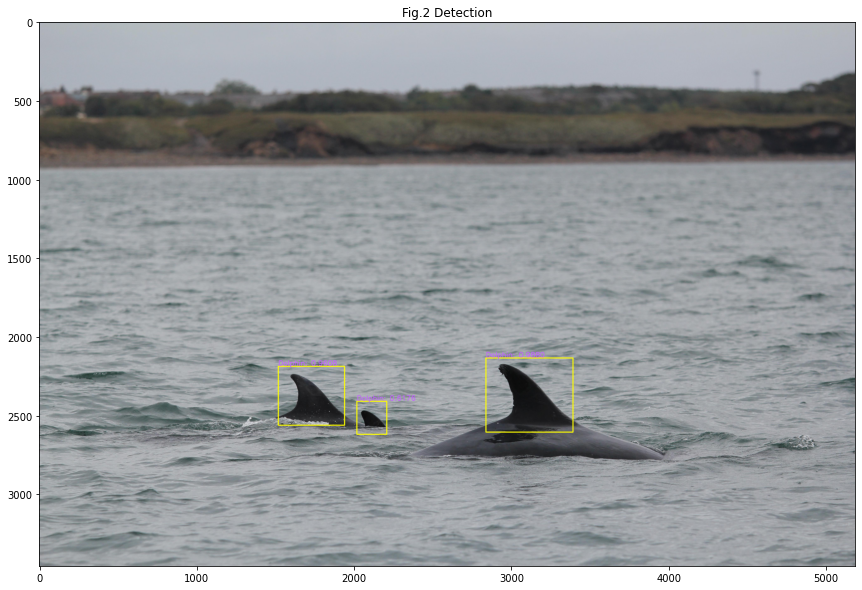

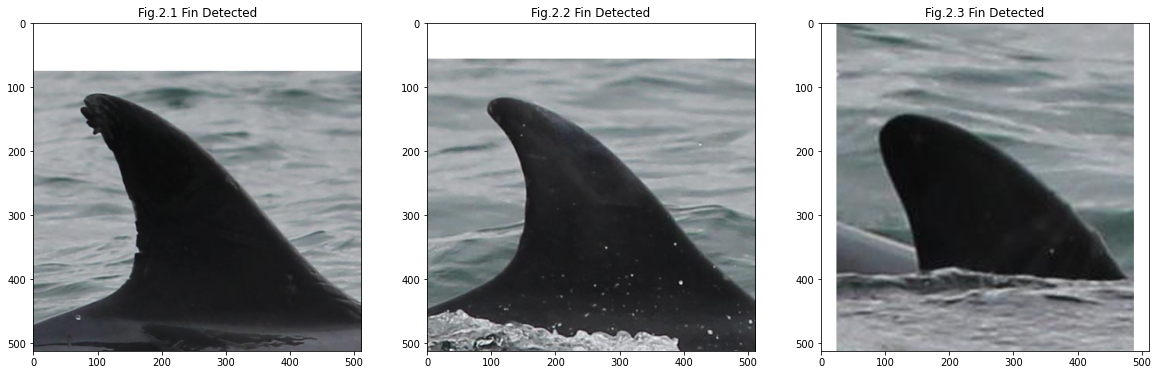

In [44]:
from feature_extract import *
import cv2
IMG_SIZE = 512

image = cv2.imread(data_dir+"/data/9.jpg")

CONFIDENCE = 0.5
THRESHOLD = 0.5    
weightsPath = os.path.sep.join([MODEL_DIR, "training/yolov4-dolphin_best.weights"])
configPath = os.path.sep.join([MODEL_DIR, "yolov4-dolphin.cfg"])
    
images, img_find = find_fin(image,weightsPath,configPath,CONFIDENCE,THRESHOLD,IMG_SIZE,255)

# number of fins found
#print(len(images))
plt.figure(figsize=(16,10))
plt.imshow(cv2.cvtColor(img_find, cv2.COLOR_BGR2RGB)); plt.title("Fig.2 Detection");
plt.figure(figsize=(20,10))
plt.subplot(131)
plt.imshow(cv2.cvtColor(images[0][0], cv2.COLOR_BGR2RGB)); plt.title("Fig.2.1 Fin Detected");
plt.subplot(132)
plt.imshow(cv2.cvtColor(images[1][0], cv2.COLOR_BGR2RGB)); plt.title("Fig.2.2 Fin Detected");
plt.subplot(133)
plt.imshow(cv2.cvtColor(images[2][0], cv2.COLOR_BGR2RGB)); plt.title("Fig.2.3 Fin Detected");


The first image above shows the input image with the detection bounding boxes of the fins found. The function includes the cropping, resizing and padding of the found fins to produce equally sized images.

## 3. Image Pre-Processing
We further process the found images to emphasise features. This process is applied to training data as well as the input data in the final matching process.

### 3.1 Feature Analysis
Dolphins can be distinct from one another by their dorsal fin's contour and pigmentation. The colour can be ignored as it varies too heavily based on lighting conditions and photo equipment used.<br>

### 3.2 Training Data
A set of training data is available in the form of labelled fins with the background removed. For some of the images the pixel data behind the 4th channel(alpha channel), which is a transparency map, have to be removed as only 3 channels (RGB/BGR) are being processed. A function for this was implemented in the file feature_extract.py.

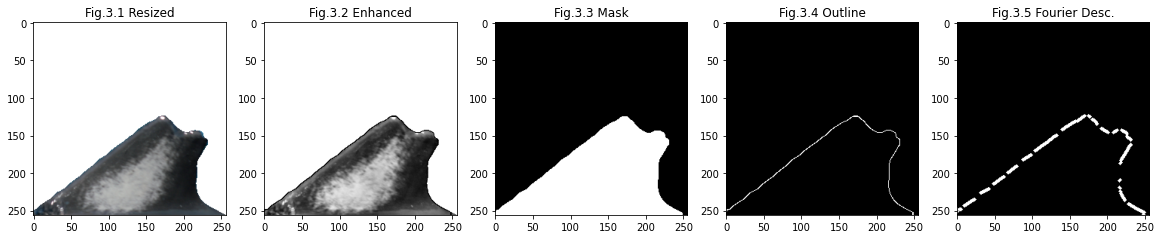

In [51]:
from feature_extract import *
IMG_SIZE = 256
images_dir = IMAGES_DIR+'/final_pigmentation_catalogue_2016'

image_x = cv2.imread(images_dir+"/0002/HG_100429_011_SD.png", cv2.IMREAD_UNCHANGED) # read alpha channel
#image_x = cv2.cvtColor(image, cv2.COLOR_BGR2BGRA)
img_rsz, img_ftr, img_mask, img_cntr, img_fd, fourier_desc, status = feature_extract(image_x, IMG_SIZE)
plt.figure(figsize=(20,10))
plt.subplot(151)
plt.imshow(cv2.cvtColor(img_rsz, cv2.COLOR_BGR2RGB)); plt.title("Fig.3.1 Resized");
plt.subplot(152)
plt.imshow(cv2.cvtColor(img_ftr, cv2.COLOR_BGR2RGB)); plt.title("Fig.3.2 Enhanced");
plt.subplot(153)
plt.imshow(cv2.cvtColor(img_mask, cv2.COLOR_BGR2RGB)); plt.title("Fig.3.3 Mask");
plt.subplot(154)
plt.imshow(cv2.cvtColor(img_cntr, cv2.COLOR_BGR2RGB)); plt.title("Fig.3.4 Outline");
plt.subplot(155)
plt.imshow(cv2.cvtColor(img_fd, cv2.COLOR_BGR2RGB)); plt.title("Fig.3.5 Fourier Desc.");

The function returns five images: a resized and background cleaned, a feature enhanced, a mask, an outline and a Fourier descriptor visualised and as data points respectively. The extractions are possible as we have a clean set of images where the mask can easily be extracted. The Fourier descriptor was implemented for experimental purposes to test whether it can be helpful in the identification process. Because no fully functional automated outline detection could be implemented on time, the used pre-processing was limited to the cleaned and feature enhanced image. A semi-manual approach was tested to apply a filter to individual images.

#### Pre-Processing
We pre-calculate all images and put them into a separate folder. The images can be created for different sizes depending on the network setup.<br>Below code will generate all images as per above in a 96x96 pixel resolution.

In [33]:
# build up some meta data
MAX_FILES = 5000
images_dir = IMAGES_DIR+'/final_pigmentation_catalogue_2016'
image_dirs = Path(images_dir) 
images = pd.DataFrame(columns=['label', 'path', 'name', 'img'], dtype=object)

for image_dir in image_dirs.glob('*'):
    label = image_dir.stem
    for file in image_dir.glob('*'):
        basename = os.path.basename(file)
        f_name, f_ext = os.path.splitext(basename)
        if f_ext.lower() != ".png" or f_name[0:3] !="HG_": continue
        images.loc[len(images)] = [label, file, f_name, ""]
    if len(images) >= MAX_FILES: break
images['date'] = pd.to_datetime(images.name.str.slice(3, 9), format='%y%m%d')

In [41]:
# generate the training data
IMG_SIZE = 96
TARGET_IMAGES_DIR = IMAGES_DIR+'/fin_features_'+str(IMG_SIZE)+"/"
img = []

for i, file in enumerate(images.itertuples()):
    image = cv2.imread(str(file.path), cv2.IMREAD_UNCHANGED) # read alpha channel

    # resized, feature enhanced, mask, contour
    img_rsz, image, img_mask, img_cntr, img_fd, fourier_desc, status = feature_extract(image,IMG_SIZE)
    #ignore the few inconsistent images
    if status == 1:
        print(file.label+ "_" + file.name + ": no alpha channel")
        continue
    if status == 2:
        print(file.label+ "_" + file.name + ": other error")
        continue
    if status == 3:
        print(file.label+ "_" + file.name + ": resize/pad error")
        continue
    
    path = os.path.join(TARGET_IMAGES_DIR, file.label)
    if not os.path.exists(path):
        os.makedirs(path)

    cv2.imwrite(TARGET_IMAGES_DIR + file.label+"/pre1_" + file.name + "_rsz_"+file.label+".png", img_rsz)    
    cv2.imwrite(TARGET_IMAGES_DIR + file.label+"/pre1_" + file.name + "_ftr_"+file.label+".png", image)
    cv2.imwrite(TARGET_IMAGES_DIR + file.label+"/pre1_" + file.name + "_mask_"+file.label+".png", img_mask)
    cv2.imwrite(TARGET_IMAGES_DIR + file.label+"/pre1_" + file.name + "_cntr_"+file.label+".png", img_cntr)
    cv2.imwrite(TARGET_IMAGES_DIR + file.label+"/pre1_" + file.name + "_fdsc_"+file.label+".png", img_fd)
    #with open(TARGET_IMAGES_DIR + "/pre1_" + file.name + "_fdsk_"+file.label+".dat", 'w') as f:
    #    data=fourier_desc.tobytes()
    np.save(TARGET_IMAGES_DIR +file.label+"/pre1_" + file.name + "_fdsk_"+file.label+".npy", fourier_desc)
    #print(file.label + ": " +str(round(fourier_desc[0].real))+":"+str(round(fourier_desc[1].real))+":"+str(round(fourier_desc[2].real))+":"+str(round(fourier_desc[3].real)) + " - " + file.name)

0009_HG_111112_038_E3_MG: no alpha channel
0009_HG_130124_129_E1_BO: no alpha channel
0009_HG_131002_959_E2_CL_AII: no alpha channel
0009_HG_131003_0556_E2_CL_AII_A: no alpha channel
0009_HG_131112_074_E1_BL: no alpha channel
0017_HG_131104_3608_E10_CL_AII_B: no alpha channel
0022_HG_130208_340_E1_KR_AII: no alpha channel
0022_HG_130208_341_E1_KR_AII: no alpha channel
0022_HG_130208_347_E1_KR_AII: no alpha channel
0023_HG_120419_048_E1_AA_N7: no alpha channel
0025_HG_120327_024_E1: no alpha channel
0031_HG_111117_151_E1_mg: no alpha channel
0031_HG_111117_156_E5_MG: no alpha channel
0031_HG_111117_243_E4: no alpha channel
0100_HG_121215_759_E2_KR_AII: no alpha channel
0100_HG_121215_801_E2_KR_AII_A: other error
0100_HG_121215_802_E2_KR_AII_A: no alpha channel
0100_HG_121215_890_E2_KR_AII: other error
0100_HG_121215_891_E2_KR_AII: other error
0100_HG_121215_892_E2_KR_AII: other error
0100_HG_130208_1193_E3_KR_AII: other error
0100_HG_130208_1195_E3_KR_AII: other error
0100_HG_130208_130

### 3.3 Input Data
Below the first fin detected from Fig.2.1 after the application of the filters.

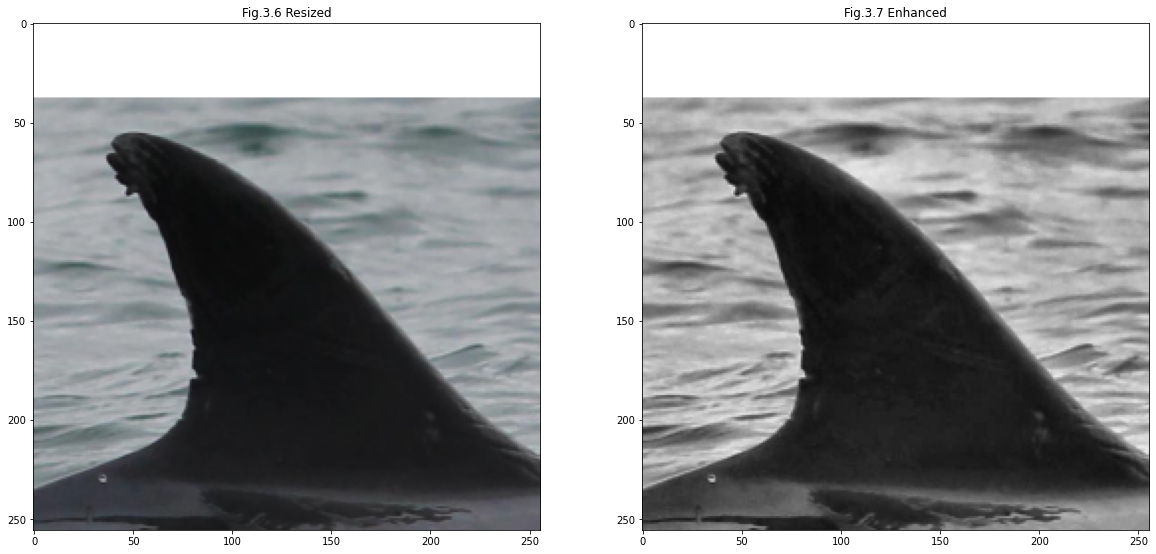

In [52]:
# the first fin from the previous fetching process is taken
image_x = cv2.cvtColor(images[0][0], cv2.COLOR_BGR2BGRA)
img_rsz, image_ftr, img_mask, img_cntr, img_fd, fourier_desc, status = feature_extract(image_x, IMG_SIZE)
plt.figure(figsize=(20,10))
plt.subplot(121)
plt.imshow(cv2.cvtColor(img_rsz, cv2.COLOR_BGR2RGB)); plt.title("Fig.3.6 Resized");
plt.subplot(122)
plt.imshow(cv2.cvtColor(image_ftr, cv2.COLOR_BGR2RGB)); plt.title("Fig.3.7 Enhanced");

By executing below code one can adjust parameters manually to create a mask for individual matching. A network can be trained based on the enhanced images which can further improve matching of individuals that could not be identified by the automated process.<br> For this project however, a fully automated process was anticipated.<BR><BR>
Any key will terminate the process once started below.

In [3]:
from detect import get_fin

image = cv2.imread(data_dir+"data/9.jpg")
img, _ = get_fin(image,0,True)    
cv2.destroyAllWindows() 
plt.figure(figsize=(8,8))
plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB)); plt.title("Fig.3.8 Enhanced by manual filter settings");

error: OpenCV(4.0.1) C:\ci\opencv-suite_1573470242804\work\modules\dnn\src\darknet\darknet_importer.cpp:207: error: (-212:Parsing error) Failed to parse NetParameter file: ../models/darknet\yolov4-dolphin.cfg in function 'cv::dnn::dnn4_v20181221::readNetFromDarknet'


## 4 Identification

The core task for this project is to automate the process of identifying dolphins. We were provided with the pigmentation catalogue by NIWA marine researchers. 

Our goal was to fit a triplet loss neural network to this data; extract the embeddings from the neural network; fit supervised and semi-supervised classifiers to these embeddings; and make predictions using these classifiers. For instance, a simple KNN classifier would be able to memorise these embeddings, and be able to classify new images that have been uploaded. A Local Outlier factor model could be used for semi-supervised novelty detection. A clustering method like K-means or DBSCAN could be used for unsupervised classification. 

### 4.1 Triplet Loss

We make use of a convolutional neural network with the triplet loss function. We have re-purposed a facial recognition algorithm, FaceNet, to detect individual dolphins. FaceNet was, at the time, a state-of-the-art siamese neural network that has made use of offline learning to identify triplets. 

At its core, a triplet is composed of an anchor input, a positive input, and a negative input. We want to minimise the Euclidean distance between the anchor and positive input, while maximising the Euclidean distance between the anchor and negative input.

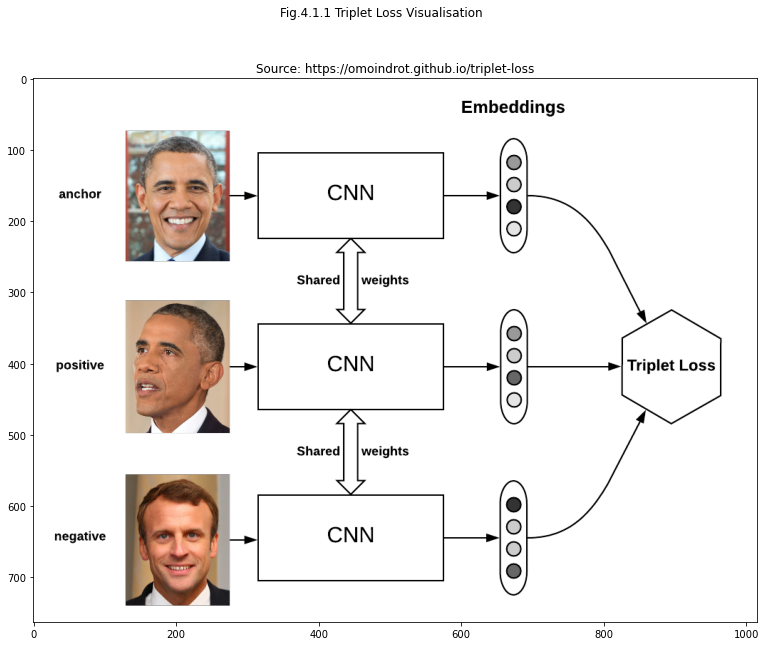

In [23]:
plt.figure(figsize=(16,10))
plt.imshow(plt.imread('images/triplet_loss_obama.png'));
plt.suptitle("Fig.4.1.1 Triplet Loss Visualisation");
plt.title("Source: https://omoindrot.github.io/triplet-loss");

We can see an excellent visualisation of this approach in fig 4.1.1. 

Three CNNs have shared weights - a siamese architecture. They will receive three different inputs, which will be fed to the triplet loss function. With enough training, the neural network will be able to recognise both Barack Obama and Emmanuel Macron. Similarly, it may be possible to identify dolphins using the pigmentation and contours of their fins.

We have performed thorough exploration and testing using a variety of networks. See notebooks 5_1_triplet_loss_dolphin_simple_architecture_no_aug, 5_2_triplet_loss_dolphin_simple_architecture_aug, 5_3_triplet_loss_dolphin_resnet_aug, and 5_4_triplet_loss_filtered_datasets for a full discussion.

We have used relatively simple architectures for our CNNs. Likewise, we have used a more complex architecture with ResNet50 as the backbone network. We apply online image augmentation to reduce over-fitting. We've tested both the Adam and Adamax optimisers. We've used online learning with hard and semi-hard triplets - the advantage of this online learning is is that we do not require a siamese network to be used. We've tested margins between 1 to 4. For our hard triplets, we've used both hard and soft margins.

We found the most solid results with a relatively simple architecture. This is elaborated upon in 5_4_triplet_loss_filtered_datasets.

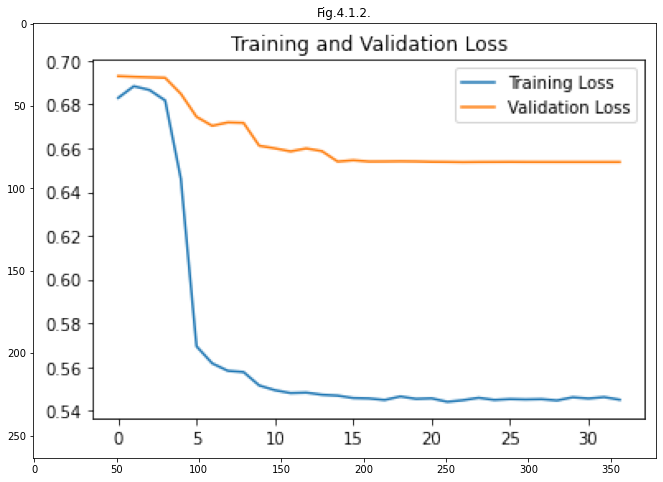

In [27]:
plt.figure(figsize=(12,8))
plt.imshow(plt.imread('images/triplet_loss_plot.png')); plt.title("Fig.4.1.2.");

Triplet loss networks are notoriously difficult to train. We see that the training and validation losses quickly reach a plateau at around 10 epochs. We've found varying results, but a lot of fine tuning is required here. 

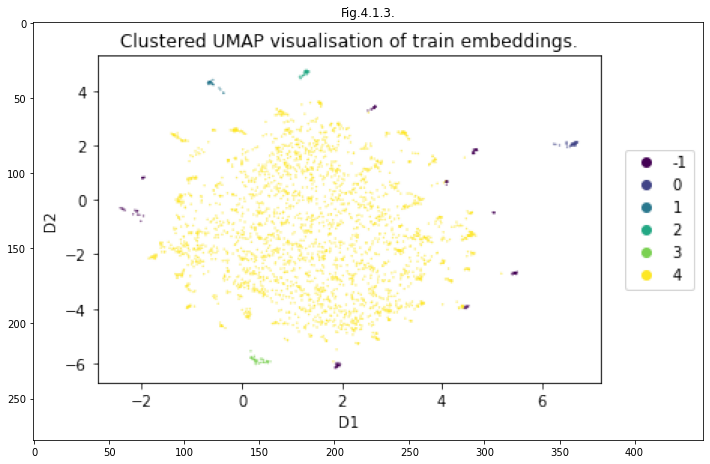

In [28]:
plt.figure(figsize=(12,8))
plt.imshow(plt.imread('images/triplet_loss_plot_clustered_umap_train.png')); plt.title("Fig.4.1.3.");

We apply HDBSCAN clustering on a UMAP visualisation of the training data embeddings. We see several outliers. These may be distinct individuals. However, the majority of data forms a Gaussian sphere. So, the separation of the observation is quite poor. Ideally, we would have distinct spherical clusters.

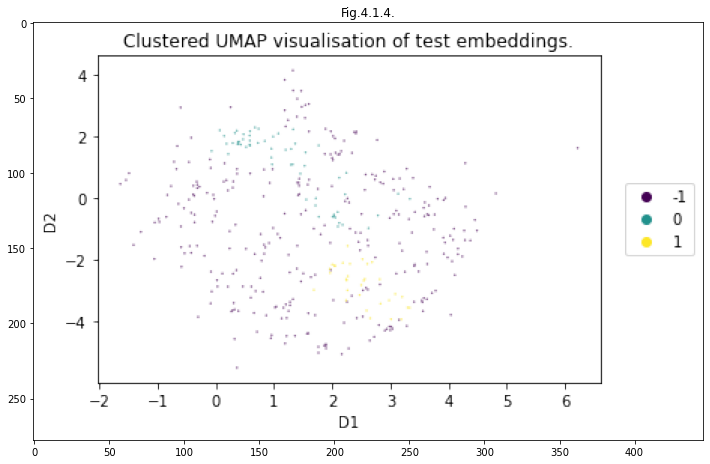

In [29]:
plt.figure(figsize=(12,8))
plt.imshow(plt.imread('images/triplet_loss_plot_clustered_umap_test.png')); plt.title("Fig.4.1.4.");

Again,we apply HDBSCAN clustering on a UMAP visualisation. This time, we are observing the testing data embeddings. The separation of the data is quite poor. More work needs to be done.

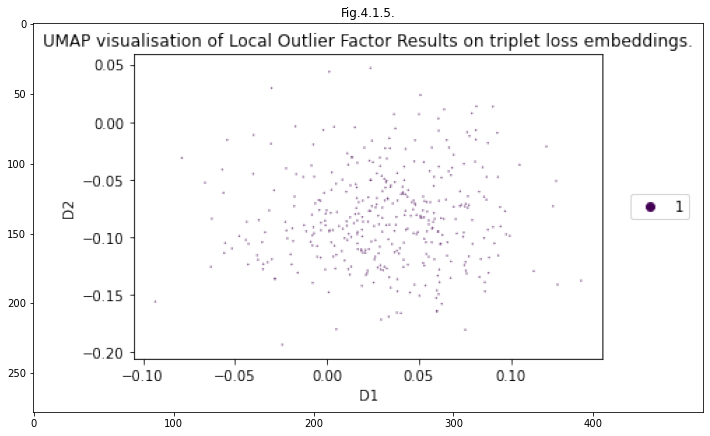

In [30]:
plt.figure(figsize=(12,8))
plt.imshow(plt.imread('images/triplet_loss_plot_lof_tl.png')); plt.title("Fig.4.1.5.");

We apply a semi-supervised Local Outlier Factor algorithm for novelty detection. LOF has failed to find anything on the triplet loss embeddings of the testing data.

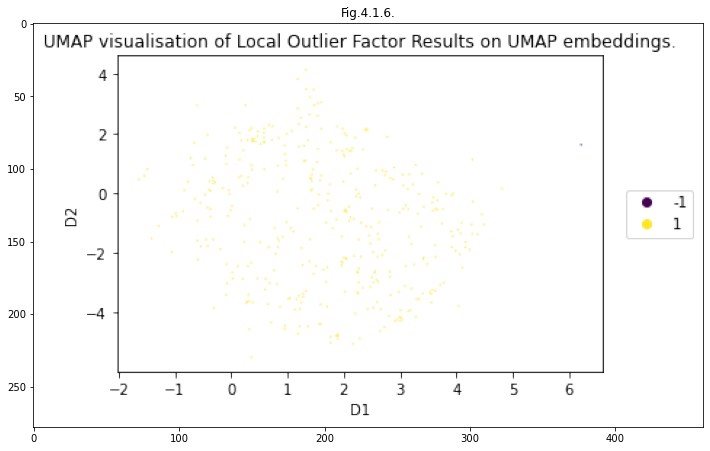

In [31]:
plt.figure(figsize=(12,8))
plt.imshow(plt.imread('images/triplet_loss_plot_lof_umap.png')); plt.title("Fig.4.1.6.");

We fit another LOF model on the UMAP test embeddings. Again, the results are clearly very poor. There is not enough separation of the data.

Finally, we've fitted two KNN classifiers. First, on the UMAP embeddings of the triplet loss embeddings. Secondly, on the triplet loss embeddings themselves. See 5_4_triplet_loss_filtered_datasets for the full training code.

<code><b>knn=KNeighborsClassifier(100)
knn.fit(mapper.embedding_, y_train)
knn.score(mapper_embeddings, y_test)
0.09162303664921466</b>
</code>

Fitting a KNN classifier on the 2D UMAP embeddings gives us a mean accuracy of around 0.09.

<code><b>knn=KNeighborsClassifier(100)
knn.fit(train_embeddings, y_train)
knn.score(test_embeddings, y_test)
0.19895287958115182</b>
</code>

Fitting a KNN classifier on the raw triplet loss embeddings gives us a mean accuracy of around 0.2. Clearly, we lose a lot of information when we reduce the dimensions of the data by such an extreme degree.

The results above suggest that a lot of work needs to be done. We need to find an approach that will allow a triplet loss network to better segregate observations of different individuals.

### 4.2 UMAP

The end goal of employing UMAP is to reduce the dimensionality of the triplet loss neural network embeddings into 2D latent space. We use it for visualisation and to improve the performance of algorithms such as KNN, Local Outlier Factor, and HDBSCAN that are particularly susceptible to the curse of dimensionality.

We initially fitted UMAP to the pigmentation dataset without the use of triplet loss. We would treat the results of this test as a baseline. 

See notebooks 1_non_parametric_unsupervised_umap_hdbscan and 2_non_parametric_supervised_umap_hdbscan for a full discussion of the results.

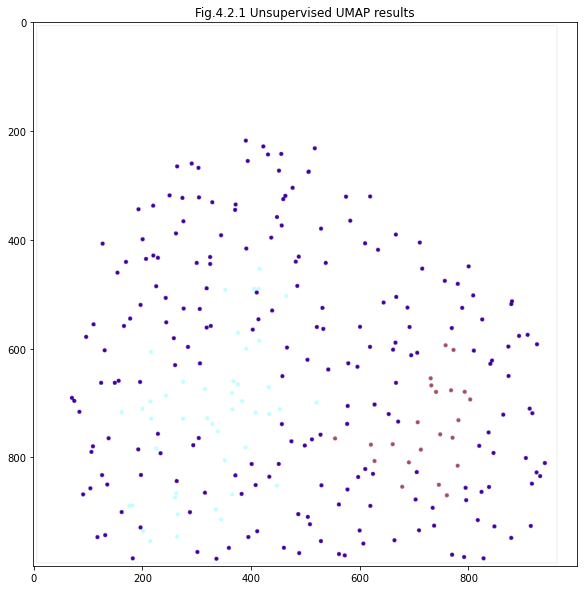

In [80]:
plt.figure(figsize=(16,10))
plt.imshow(plt.imread('images/unsupervised_umap.png')); plt.title("Fig.4.2.1 Unsupervised UMAP results");

As you can see, UMAP has failed to segment the data by individuals. We are left with a large data cloud. We next repeat this process using supervised UMAP.

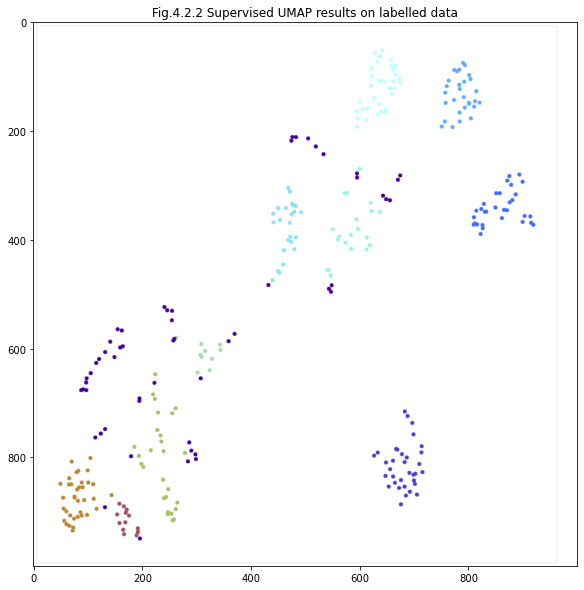

In [81]:
plt.figure(figsize=(16,10))
plt.imshow(plt.imread('images/supervised_umap.png')); plt.title("Fig.4.2.2 Supervised UMAP results on labelled data");

We can see the results are much better. UMAP is able to segment the data cloud by class. We apply this trained UMAP model on un-labelled data.

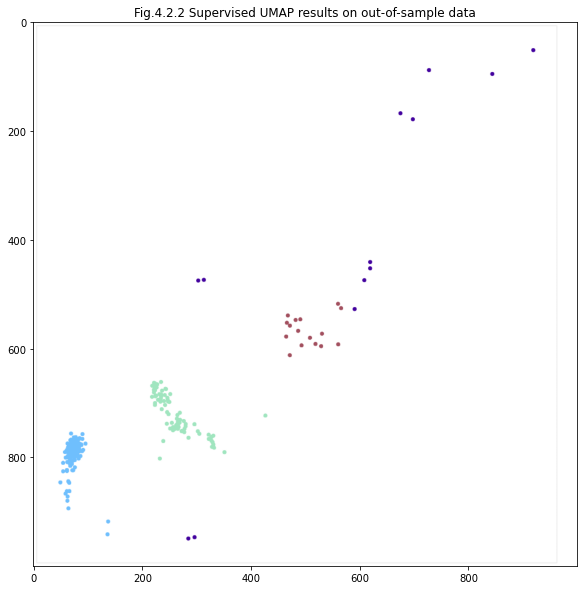

In [82]:
plt.figure(figsize=(16,10))
plt.imshow(plt.imread('images/supervised_umap_label.png')); plt.title("Fig.4.2.2 Supervised UMAP results on out-of-sample data");

### 4.3 Implementation
Due to poor results from the testing we decided to try to utilise a FaceNet implementation as a fallback and modify it to work with the fin dataset.<br> The code it is based on was taken from:<br>
https://github.com/sainimohit23/FaceNet-Real-Time-face-recognition<br>
https://github.com/iwantooxxoox/Keras-OpenFace/<br>
The sources have been acknowledget in the files that contain parts of them.<br>
#### 4.3.1 Files
parameters.py - set some environment variables and parameters used in training and execution<br>
train_triplet.py - used for training the network<br>
predict.py - executes the prediction based on files found in the input directory<br>
<br><br>
<b>Other supporting files:<br></b>
generator_utils - file processing for training set<br>
fr_utils - some helper functions for image encoding and loading of default weights<br>
inception_blocks_v2.py - model definition for FaceNet<br>
### 4.4 Training
The network was trained using 50 epochs each 100 steps and an Alpha value of 0.4

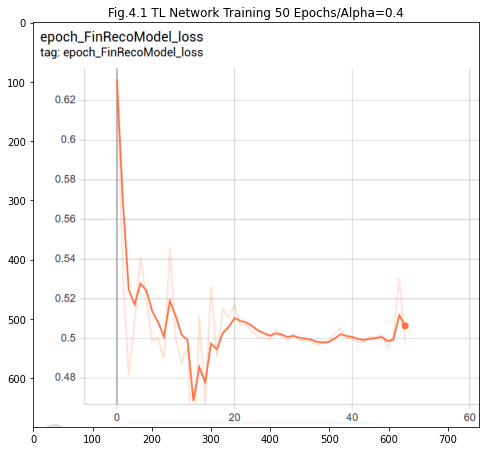

In [71]:
image = cv2.imread(MODEL_DIR_TL+"/training_loss_1.png") 
plt.figure(figsize=(8,8))
plt.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB)); plt.title("Fig.4.1 TL Network Training 50 Epochs/Alpha=0.4");

## 5 Web Application 

A web application was built to support the machine learning pipeline.

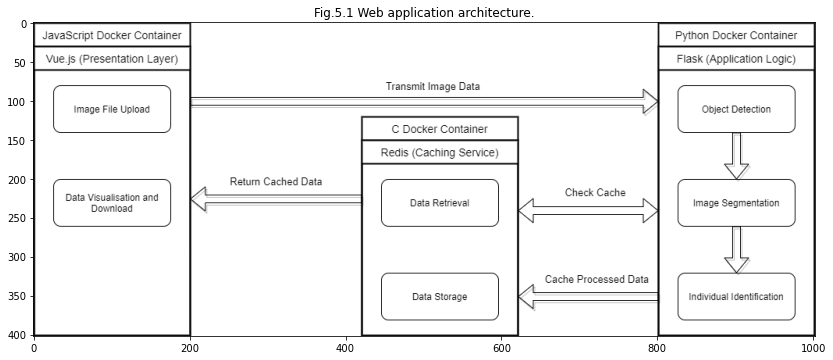

In [16]:
plt.figure(figsize=(14,8))
plt.imshow(plt.imread('images/dolphin_identification_architectural_plan.png')); plt.title("Fig.5.1 Web application architecture.");

A Vue.js front-end was built for the application's GUI. This was complemented by a Flask backend, which served the application's functionality via a REST API. Both frameworks were chosen as they are relatively light-weight, so they were invaluable for rapid application development.

Redis acted as a caching service, job queue, and message broker. Celery workers were used to perform asynchronous operations, preventing the web application from receiving a negative performance impact due to the computational complexity of the machine learning pipeline. Celey made extensive use of the Redis backend to faciliate coordination between workers.

The entire application was deployed using a containerised Docker stack. This provided automated deployment within a shared and consistent environment.

Nginx was used to improve the application's performance by acting as a load balancer and caching service. It is particularly performant for serving images and files, especially when compared with Flask.

A flat-file database system was used to store image processing tasks, as there is minimal persistent data storage required for the application.

The project's GitHub repository can be found here: https://github.com/JBris/dolphin_segmentation

We will view the application's pages:

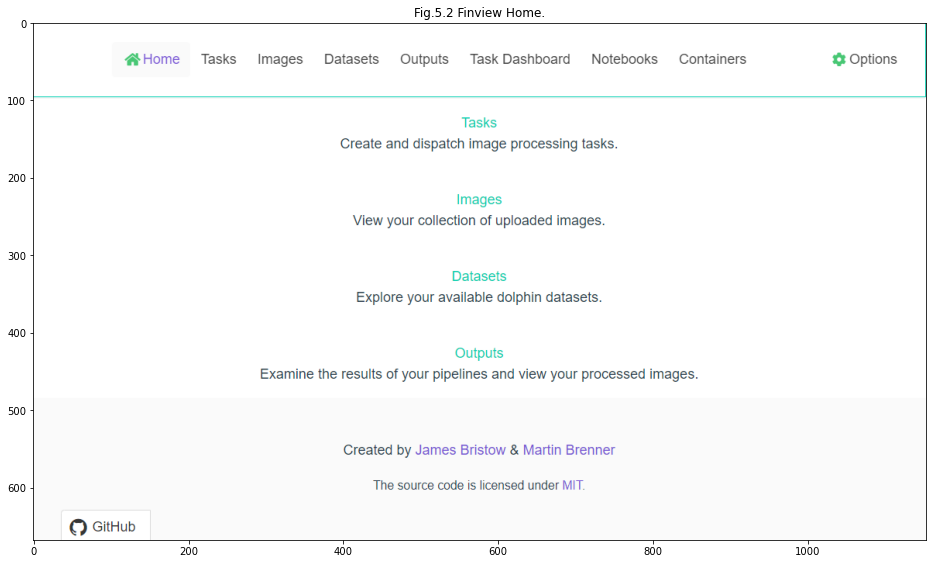

In [7]:
plt.figure(figsize=(16,10))
plt.imshow(plt.imread('images/finview_home.png', cv2.COLOR_BGR2RGB)); plt.title("Fig.5.2 Finview Home.");

The application is composed of four main pages: Tasks, Images, Datasets, and Outputs. 

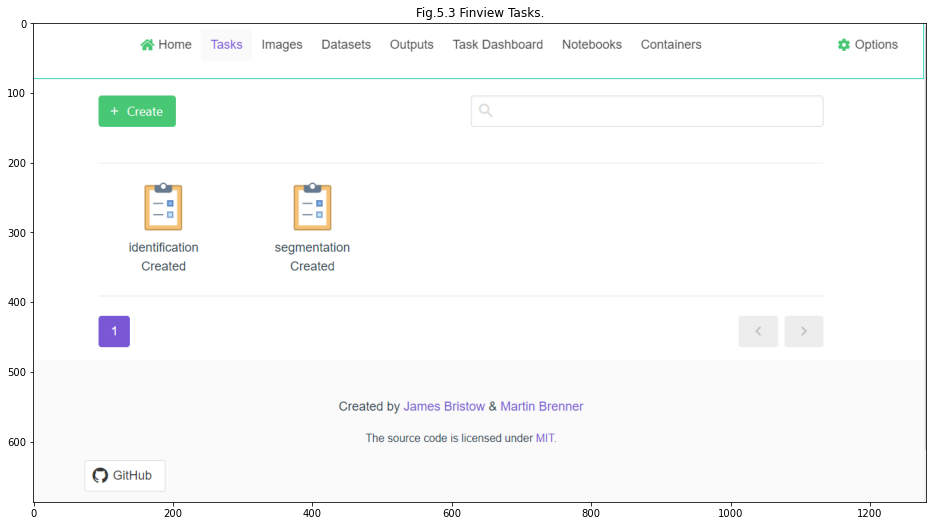

In [8]:
plt.figure(figsize=(16,10))
plt.imshow(plt.imread('images/finview_tasks.png', cv2.COLOR_BGR2RGB)); plt.title("Fig.5.3 Finview Tasks.");

With Tasks, we create and dispatch image processing pipelines. Users may choose between segmentation and identification tasks. 

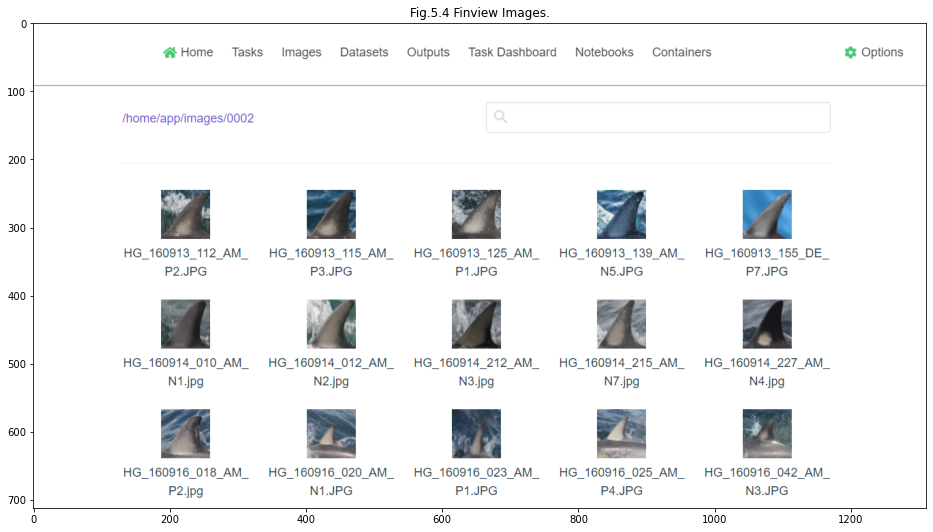

In [9]:
plt.figure(figsize=(16,10))
plt.imshow(plt.imread('images/finview_images.png', cv2.COLOR_BGR2RGB)); plt.title("Fig.5.4 Finview Images.");

Users may view their images in the Images section. They can also perform basic file operations: Copying, archiving, moving, and deletion.

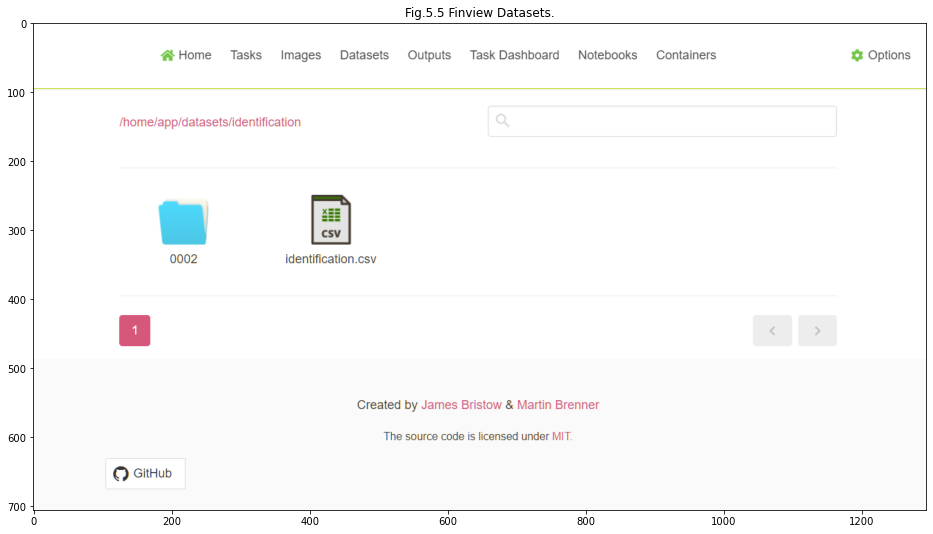

In [120]:
plt.figure(figsize=(16,10))
plt.imshow(cv2.imread('images/finview_datasets.png', cv2.COLOR_BGR2RGB)); plt.title("Fig.5.5 Finview Datasets.");

Processed dataset results are placed in the Datasets section as csv or json files. Users may select and visualise these files.

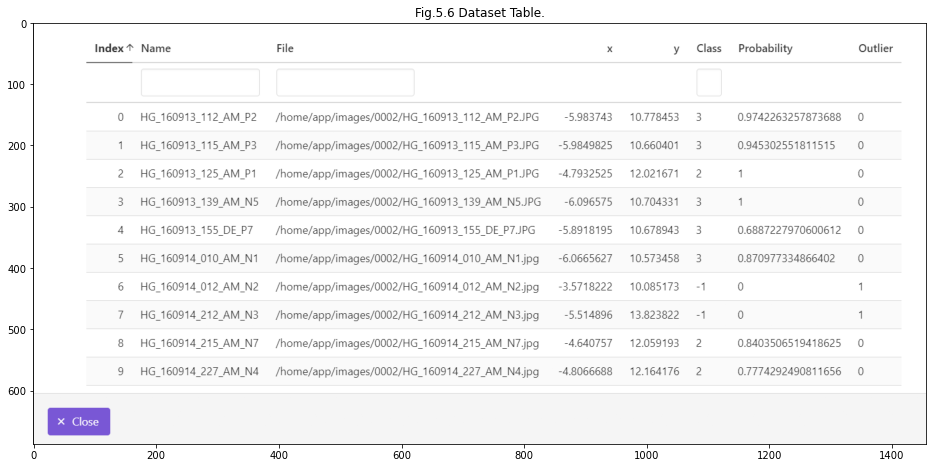

In [11]:
plt.figure(figsize=(16,10))
plt.imshow(plt.imread('images/dataset_table.png')); plt.title("Fig.5.6 Dataset Table.");

We can see above a tabular representation of the processed data. The image name and path are provided. The x and y coordinates of the first two dimensions within latent space are also shown. The class membership is depicted; following Sklearn's convention, a value of -1 means that the image is an outlier. The probability of class membership is shown. Finally, we have a flag indicating whether the image is an outlier.

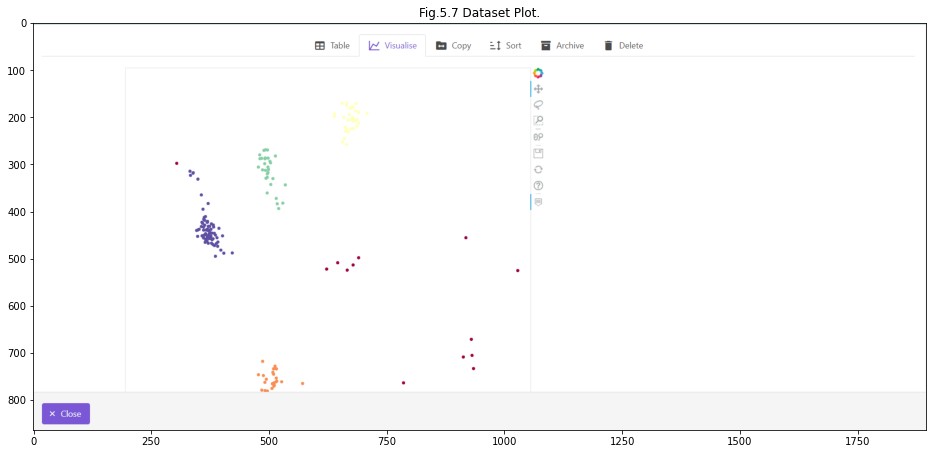

In [12]:
plt.figure(figsize=(16,10))
plt.imshow(plt.imread('images/dataset_plot.png')); plt.title("Fig.5.7 Dataset Plot.");

There is also an interactive 2D visualisation of this data. Hovering over a point will render a thumbnail of the image. Various selection tools are also provided on the right.

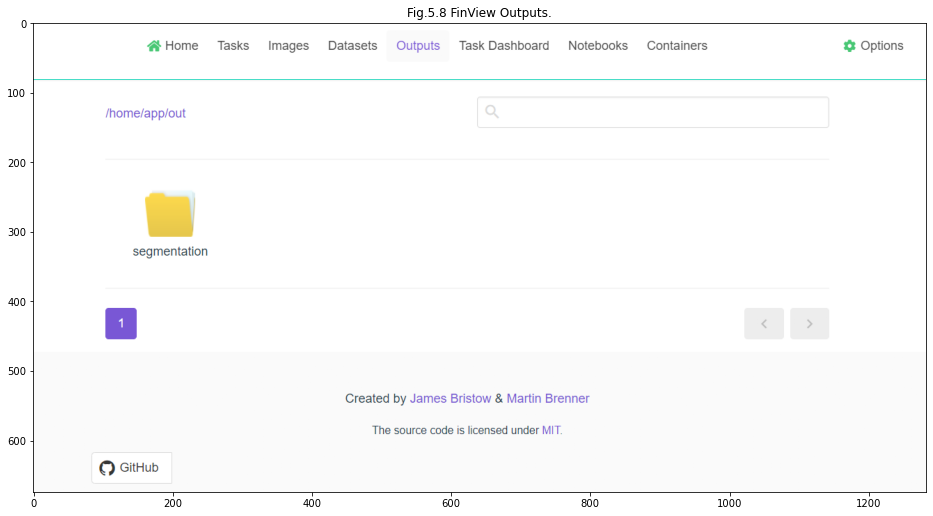

In [13]:
plt.figure(figsize=(16,10))
plt.imshow(plt.imread('images/finview_outputs.png')); plt.title("Fig.5.8 FinView Outputs.");

The output section is used to show segmented or classified images - outputs of the image processing pipeline. 

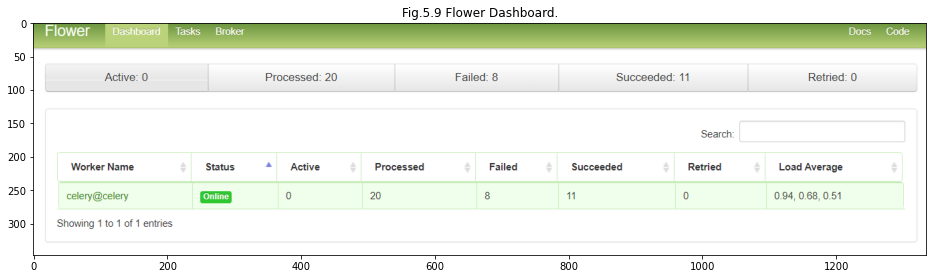

In [14]:
plt.figure(figsize=(16,10))
plt.imshow(plt.imread('images/flower.png', )); plt.title("Fig.5.9 Flower Dashboard.");

A Flower dashboard is also included to manage individual Celery workers, as they perform their assigned tasks in an asynchronous manner. It's also possible to view the status of individual tasks - whether they have failed or succeeded.

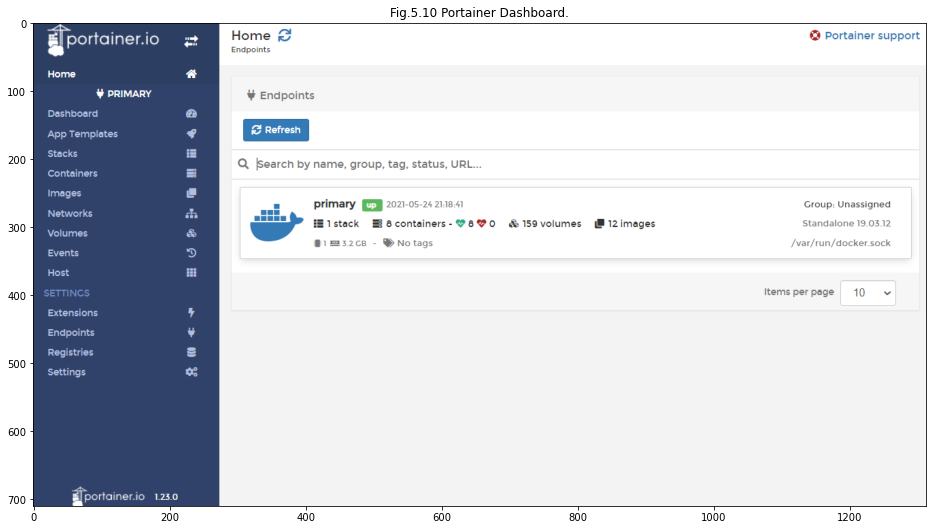

In [15]:
plt.figure(figsize=(16,10))
plt.imshow(plt.imread('images/portainer.png', cv2.COLOR_BGR2RGB)); plt.title("Fig.5.10 Portainer Dashboard.");

Finally, a Portainer dashboard is included so that users may view and manage the Docker stack.

## 6 Conclusion

We have attempted to build an automation pipeline to assist marine researchers with their efforts in identifying individual dolphins based on their dorsal fins.

=======================EDA and feature extraction=============================

A system has been developed to take file or directory containing images of dorsal fins. These fin images will be processed by a trained, YOLOv4 DarkNet model. Fins will be detected and segmented from the surrounding background of supplied images. We note that the process of training and applying this model was relatively trivial. The theory and technologies behind object detection are well-developed, mature, and robust. We saw excellent results with respect to its MAP and IoU scores.

However, it was much more difficult to train a triplet loss model. We found that our networks required significant hyperparameter tuning, and that they were very prone to collapsing. The validation loss would very easily plateau.

We developed a web application using Vue.js and Flask. By using marine researchers as beta test users of this system, we believe that there is significant future potential for this application. We will take in their feedback, and further develop its feature set.

In terms of future work, we will explore the use of Deep Extreme Cut as an alternative segmentation system. Moreover, after improving our implementation of triplet loss, we will subsequently fit a supervised KNN classifier on the neural network embeddings for information retrieval on catalogued individuals. We will also fit a semi-supervised Local Outlier Factor model on these embeddings for novelty detection. We found that the results of our current KNN and LOF classifiers were quite poor. This will be an area of future improvement. 